# Convolutional Autoencoder

Let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
"préparation des données"
path = 'lips//res//frame'
nframe=2000

trainingLength = int(0.9*nframe)   #Nombre de frame que l'on garde pour l'entrainement, le reste sera pour le test
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

image1 = rgb2gray(mpimg.imread(path  + str(1) + '.jpg')) #Load the first image

imageSize = image1.shape
num_inputs=imageSize[0]*imageSize[1]  # taille image entrée si les images ont bien été resized

lips = np.zeros((nframe,imageSize[0], imageSize[1]))

for i in range(1,nframe-1):
#    print(len(mpimg.imread(path  + str(i+1) + '.jpg')))
#    print(len(mpimg.imread(path  + str(i+1) + '.jpg')[0]))
#    lips[i-1] = np.reshape(mpimg.imread(path  + str(i+1) + '.jpg',grayscale),(41*69,1))
#    Without resizing :
    lips[i-1] = rgb2gray(mpimg.imread(path  + str(i) + '.jpg'))

lipsTrain=lips[:trainingLength]
lipsTest=lips[trainingLength:]

CNN Autoencodeur


In [3]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(tf.float32, (None, 48,80,1), name="input")
targets_ = tf.placeholder(tf.float32, (None, 48,80,1), name="target")

### Encoder
with tf.name_scope("convolution1"):
    conv1 = tf.layers.conv2d(inputs=inputs_, filters=16, kernel_size=(3,3), padding='same', activation=tf.nn.relu, name="convolution1")
    # Now 48x80x16
    maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=(2,2), strides=(2,2), padding='same', name="pooling1")
    # Now 24x40x16
with tf.name_scope('convolution2'):
    conv2 = tf.layers.conv2d(inputs=maxpool1, filters=8, kernel_size=(3,3), padding='same', activation=tf.nn.relu, name="convolution2")
    # Now 24x40x8
    maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=(2,2), strides=(2,2), padding='same', name="pooling2")
    # Now 12x20x8
with tf.name_scope('convolution3'):
    conv3 = tf.layers.conv2d(inputs=maxpool2, filters=8, kernel_size=(3,3), padding='same', activation=tf.nn.relu, name="convolution3")
    # Now 12x20x8
    encoded = tf.layers.max_pooling2d(conv3, pool_size=(2,2), strides=(2,2), padding='same', name="pooling3")
    # Now 6x10x8

### Decoder
with tf.name_scope("convolution4"):
    upsample1 = tf.image.resize_images(encoded, size=(12,20), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # Now 6x10x8
    conv4 = tf.layers.conv2d(inputs=upsample1, filters=8, kernel_size=(3,3), padding='same', activation=tf.nn.relu, name="convolution4")
    # Now 6x10x8
with tf.name_scope('convolution5'):
    upsample2 = tf.image.resize_images(conv4, size=(24,40), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # Now 12x20x8
    conv5 = tf.layers.conv2d(inputs=upsample2, filters=8, kernel_size=(3,3), padding='same', activation=tf.nn.relu, name="convolution5")
    # Now 24x40x8
with tf.name_scope('convolution6'):
    upsample3 = tf.image.resize_images(conv5, size=(48,80), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # Now 48x80x8
    conv6 = tf.layers.conv2d(inputs=upsample3, filters=16, kernel_size=(3,3), padding='same', activation=tf.nn.relu, name="convolution6")
    # Now 48x80x16

with tf.name_scope('convolution7'):
    logits = tf.layers.conv2d(inputs=conv6, filters=1, kernel_size=(3,3), padding='same', activation=None, name="convolution7")
    #Now 48x80x1

    # Pass logits through sigmoid to get reconstructed image
    decoded = tf.nn.sigmoid(logits)

    # Pass logits through sigmoid and calculate the square loss
    loss = tf.square(targets_-logits)
# tf.summary.histogram("loss", loss)
# tf.summary.scalar("loss",loss)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
# We should use : tf.losses.mean_squared_error(targets,logits) it's more efficient

tf.summary.scalar("cost",cost)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [4]:
# Tensorboard treatment
summ = tf.summary.merge_all()

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [5]:
sess = tf.Session()

In [6]:
# TensorBoard treatment
writer = tf.summary.FileWriter('tmp/CNN/5', sess.graph)

In [7]:
num_epochs = 4
batch_size = 50
num_batch = len(lipsTrain)//batch_size
sess.run(tf.global_variables_initializer())
for epoch in range(num_epochs):
    for iteration in tqdm(range(num_batch)):
        batch = lipsTrain[iteration*batch_size:(iteration+1)*batch_size]
        imgs = batch.reshape((-1, 48, 80, 1))
        _,s,batch_cost = sess.run([opt,summ, cost], feed_dict={inputs_: imgs,
                                                         targets_: imgs})
        writer.add_summary(s,iteration+epoch*num_batch)


#         print("Epoch: {}/{}...".format(epoch+1, num_epochs),
#               "Training loss: {:.4f}".format(batch_cost))

100%|██████████| 36/36 [00:08<00:00,  4.44it/s]


InvalidArgumentError: You must feed a value for placeholder tensor 'target' with dtype float and shape [?,48,80,1]
	 [[node target (defined at <ipython-input-3-61023e66aac5>:4)  = Placeholder[dtype=DT_FLOAT, shape=[?,48,80,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'target', defined at:
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/tornado/gen.py", line 346, in wrapper
    runner = Runner(result, future, yielded)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/tornado/gen.py", line 1080, in __init__
    self.run()
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3209, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-61023e66aac5>", line 4, in <module>
    targets_ = tf.placeholder(tf.float32, (None, 48,80,1), name="target")
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1747, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5206, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/pl3/anaconda3/envs/TraduireDesVisages/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'target' with dtype float and shape [?,48,80,1]
	 [[node target (defined at <ipython-input-3-61023e66aac5>:4)  = Placeholder[dtype=DT_FLOAT, shape=[?,48,80,1], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


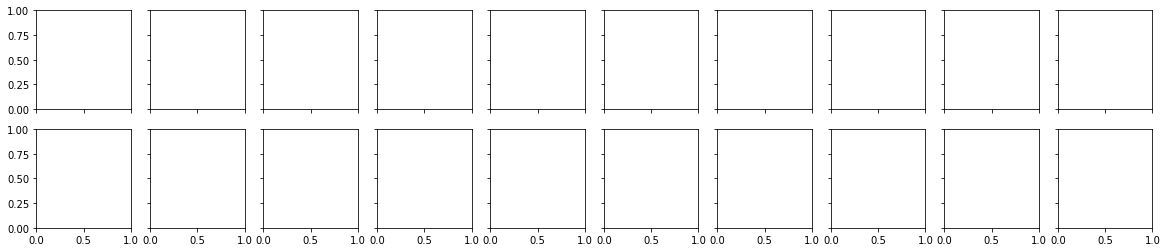

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = lipsTest[:10]
reconstructed,_ = sess.run([logits, summ], feed_dict={inputs_: in_imgs.reshape((10, 48, 80, 1))})
writer.add_summary(reconstructed)

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((48, 80)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [ ]:
sess.close()